In [134]:
!pip install qulacs
!pip install qulacsvis
!pip install matplotlib
!pip install numpy
!pip install scipy

In [75]:
from qulacs import Observable, QuantumState, QuantumCircuit, ParametricQuantumCircuit
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from qulacsvis import circuit_drawer

## 表現できる関数の予測

Y回転ゲート
$$\begin{eqnarray}
\left(R_y\left(x\right)|0\rangle\right)^{\otimes 2} &=& \left\{\cos{\left(\frac{x}{2}\right)}|0\rangle+\sin{\left(\frac{x}{2}\right)}|1\rangle\right\}^{\otimes 2}\\
  &=& \cos^2{\left(\frac{x}{2}\right)}|00\rangle +\cos{\left(\frac{x}{2}\right)}\sin{\left(\frac{x}{2}\right)}|01\rangle\\
  &+&\sin{\left(\frac{x}{2}\right)}\cos{\left(\frac{x}{2}\right)}|10\rangle+\sin^2{\left(\frac{x}{2}\right)}|11\rangle
\end{eqnarray}$$
を用いて、

パラメータ付き回路を作用させた後の状態を$|\Psi\left(x,\boldsymbol{\theta}\right)\rangle$とすると$$|\Psi\left(x,\boldsymbol{\theta}\right)\rangle=U\left(\boldsymbol{\theta}\right)\left(R_{y1}\left(x\right)\otimes R_{y2}\left(x\right)\right)|00\rangle$$


期待値$\langle\Psi\left(x,\boldsymbol{\theta}\right)|Z|\Psi\left(x,\boldsymbol{\theta}\right\rangle)$を計算すると、

$$\langle i|U^\dagger\left(\boldsymbol{\theta}\right)ZU\left(\boldsymbol{\theta}\right)|j\rangle\equiv B_{ij}$$

$$\begin{eqnarray}
\langle\Psi\left(x,\boldsymbol{\theta}\right)|Z|\Psi\left(x,\boldsymbol{\theta}\right\rangle) &=& \cos^4{\left(\frac{x}{2}\right)}B_{00}\\
&+&\cos^3{\left(\frac{x}{2}\right)}\sin{\left(\frac{x}{2}\right)}\left(B_{01}+B_{10}+B_{02}+B_{20}\right)\\
&+&\cos^2{\left(\frac{x}{2}\right)}\sin^2{\left(\frac{x}{2}\right)}\left(B_{03}+B_{30}+B_{11}+B_{12}+B_{21}+B_{22}\right)\\
&+&\cos{\left(\frac{x}{2}\right)}\sin^3{\left(\frac{x}{2}\right)}\left(B_{13}+B_{31}+B_{23}+B_{32}\right)\\
&+&\sin^4{\left(\frac{x}{2}\right)}B_{33}
\end{eqnarray}$$

これらの三角関数で表現できる関数であれば、フィッティングできる。

今回は、フィッティングを少ないサンプル数で実現できるようにするために、次数が低く、単純な関数な関数を$B_{00}$と$B_{11}$の係数に着目して式変形していく。

$$\begin{eqnarray}
\sin^4{\left(\frac{x}{2}\right)}&=&\sin^2{\left(\frac{x}{2}\right)}\left\{1-\cos^2{\left(\frac{x}{2}\right)}\right\}\\
&=&\sin^2{\left(\frac{x}{2}\right)}-\sin^2{\left(\frac{x}{2}\right)}\cos^2{\left(\frac{x}{2}\right)}\\
&=&\frac{1}{2}-\underline{\frac{\cos{x}}{2}}-\frac{1}{4}\sin^2{x}
\end{eqnarray}$$

$$\begin{eqnarray}
\cos^4{\left(\frac{x}{2}\right)}&=&\cos^2{\left(\frac{x}{2}\right)}\left\{1-\sin^2{\left(\frac{x}{2}\right)}\right\}\\
&=&\cos^2{\left(\frac{x}{2}\right)}-\sin^2{\left(\frac{x}{2}\right)}\cos^2{\left(\frac{x}{2}\right)}\\
&=&\frac{1}{2}+\underline{\frac{\cos{x}}{2}}-\frac{1}{4}\sin^2{x}
\end{eqnarray}$$

$B_{00}$と$B_{11}$の係数には演習でフィッティングした$\sin^2{x}$の関数が含まれているのに加えて$\cos{x}$の項が$\sin^2{x}$とは逆符号の係数で含まれていることから、$\cos{x}$をフィッティングする関数とする。

## 回路作成と出力の定義

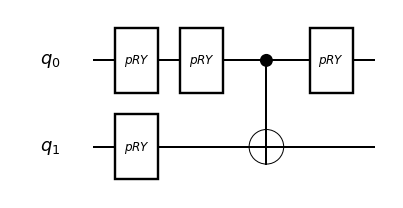

In [121]:
n_qubits = 2
circuit = ParametricQuantumCircuit(n_qubits)

# add input gate
circuit.add_parametric_RY_gate(0, 0.0)
circuit.add_parametric_RY_gate(1, 0.0)

# add parametrized circuit
circuit.add_parametric_RY_gate(0, 0.0)
circuit.add_CNOT_gate(0,1)
circuit.add_parametric_RY_gate(0, 0.0)

circuit_drawer(circuit, "mpl")

出力 (予測値) は 1 qubit 目の $Z$ 期待値を取ることにする。1次元 (スカラー) の入力データと、パラメータ $\theta = (\theta_0, \theta_1)$ を受け取って、サンプリングによって出力を返す関数を作る。

In [122]:
state = QuantumState(n_qubits)
observable = Observable(n_qubits)
observable.add_operator(1., "Z 0")
def predict(x, theta, n_shots=1000):
    
    # the first two parameters are the input gates
    circuit.set_parameter(0, x)
    circuit.set_parameter(1, x)
    
    # the next two parameters are the parametric (trainable) gates
    circuit.set_parameter(2, theta[0])
    circuit.set_parameter(3, theta[1])
    
    # run circuit and sample
    state.set_zero_state()
    circuit.update_quantum_state(state)
    
    # if n_shots is inf, return exact expectation value
    if n_shots == np.inf:
        return observable.get_expectation_value(state)
    
    # else perform sampling
    else:
        samples = np.array(state.sampling(n_shots))
        # the first qubit is the output qubit
        return np.sum((-1)**(samples%2))/n_shots

## データの用意

今回のモデルは $\cos{x}$ を完璧に表現することのできるモデルになっている。。そこで教師データとして $\cos{x}$ にノイズを加えたものを用意して、それを学習させることにする。

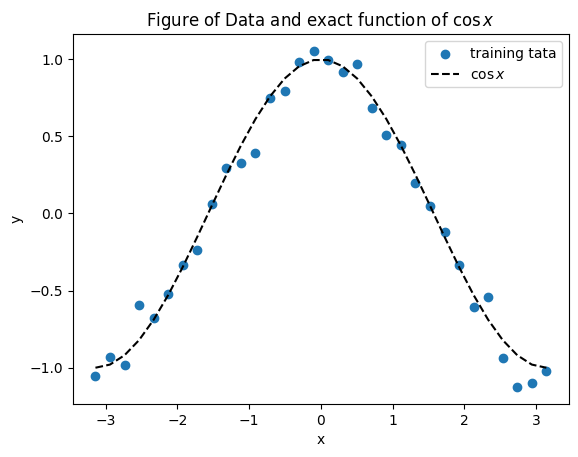

In [146]:
n_data = 32
X = np.linspace(-np.pi, np.pi,n_data)
y_clean = np.cos(X)
y = y_clean + np.random.randn(n_data)*0.1
plt.scatter(X,y,label="training tata")
plt.plot(X, y_clean, color="black", linestyle="dashed", label="$\cos{x}$")
plt.title("Figure of Data and exact function of $\cos{x}$")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.show()

## コスト関数の定義と可視化
入力データ $x_i$ と教師データ $y_i$ のセット $\{(x_i, y_i)\}$ とパラメータ $\theta$ を与えると、コスト関数の値を返すような関数を定義する。
$$L(\theta) = \sum_i (y_i - \langle Z(x_i,\theta)\rangle)^2$$

In [124]:
def get_cost(X, y, theta, n_shots=1000):
    predictions = np.zeros_like(X)
    for i, x in enumerate(X):
        predictions[i] = predict(x, theta, n_shots)
    return np.sum((predictions - y)**2)

このコスト関数がどのような形をしているか、可視化する。正確なコスト関数の値を知りたいので、ここでは `n_shots=np.inf` として、厳密な期待値をプロットする。

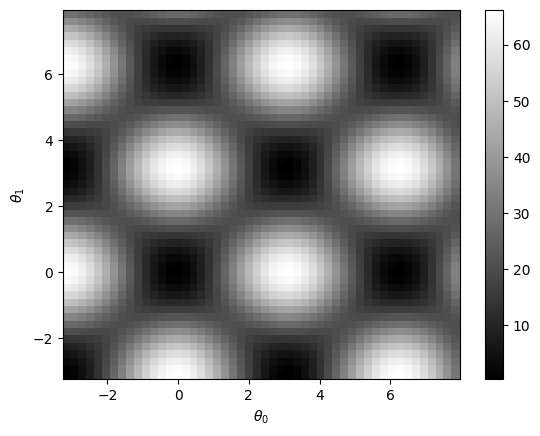

In [125]:
theta0 = np.linspace(-np.pi, 5*np.pi/2, 50)
theta1 = np.linspace(-np.pi, 5*np.pi/2, 50)
theta0, theta1 = np.meshgrid(theta0, theta1)
cost_grid = np.zeros_like(theta0)
n_shots = 1000
for i in range(50):
    for j in range(50):
        cost_grid[i,j] = get_cost(X, y, [theta0[i,j], theta1[i,j]], n_shots=np.inf)
plt.pcolor(theta0, theta1, cost_grid, shading="nearest", cmap="gray")
plt.xlabel(r"$\theta_0$")
plt.ylabel(r"$\theta_1$")
plt.colorbar()
plt.show()

## 勾配を計算する関数を準備する
[パラメータシフト法](./06_parameter_shift_rule.ipynb) を使った勾配最適化を行うため、コスト関数の勾配は
$$
\begin{align}
\frac{\partial L}{\partial \theta} &= \frac{\partial }{\partial \theta} \sum_i (y_i - \langle Z(x_i,\theta)\rangle)^2 \\
&= \sum_i 2(\langle Z(x_i,\theta)-y_i\rangle)\frac{\partial \langle Z(x_i,\theta)\rangle}{\partial \theta}
\end{align}
$$
を用いる。

In [126]:
# calculate d<Z>/d\theta 
def get_prediction_grad(x, theta, n_shots=1000):
    grad_vector = np.zeros_like(theta)
    tmp_theta = np.copy(theta)
    for i in range(len(theta)):
        tmp_theta[i] += np.pi/2
        plus = predict(x, tmp_theta, n_shots)
        tmp_theta[i] -= np.pi
        minus = predict(x, tmp_theta, n_shots)
        grad_vector[i] = (plus-minus)/2
        tmp_theta[i] = theta[i]
    return grad_vector

# calculate dL/d\theta
def get_cost_gradient(X, y, theta, n_shots=1000):
    predictions = np.zeros_like(X)
    prediction_grads = np.zeros((len(X),len(theta)))
    cost_gradient = np.zeros_like(theta)
    for i, x in enumerate(X):
        predictions[i] = predict(x, theta, n_shots)
        prediction_grads[i] = get_prediction_grad(x, theta, n_shots)
    return np.sum(2*(predictions-y)*prediction_grads.T, axis=1)

正しく計算できていることを、有限差分と比較して確認する。

In [127]:
# get gradient of general function f(\theta) by finite difference
def get_gradient_by_finite_diff(f, params, eps=1e-6):
    grad_vector = np.zeros_like(params)
    tmp_params = np.copy(params)
    for i in range(len(params)):
        tmp_params[i] += eps
        plus = f(tmp_params)
        tmp_params[i] -= 2*eps
        minus = f(tmp_params)
        grad_vector[i] = (plus-minus)/2/eps
        tmp_params[i] = params[i]
    return grad_vector

print(get_gradient_by_finite_diff(lambda theta: get_cost(X,y,theta,n_shots=np.inf), [0.3, 0.4]))
print(get_cost_gradient(X,y,[0.3,0.4],n_shots=np.inf))

[9.15505554 7.33129219]
[9.15505554 7.33129219]


## 勾配法による学習
上のカラープロットから、学習の初期パラメータ $\theta_{\mathrm{init}}$ として良さげな (見栄えが良くなりそうな) 点を選ぶ。ここでは $\theta=(3.1,2.0)$ を取ることにする。

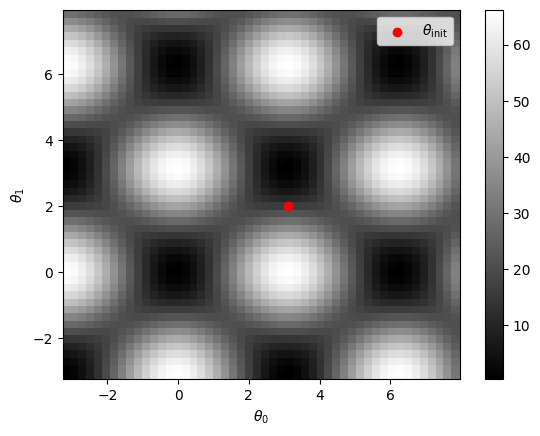

In [129]:
theta_init = np.array([3.1, 2.0])
plt.pcolor(theta0, theta1, cost_grid, shading="nearest", cmap="gray")
plt.colorbar()
plt.scatter(*theta_init, color="red", label=r"$\theta_{\mathrm{init}}$")
plt.xlabel(r"$\theta_0$")
plt.ylabel(r"$\theta_1$")
plt.legend()
plt.show()

単純な勾配降下法によって学習して、その様子を可視化すると、

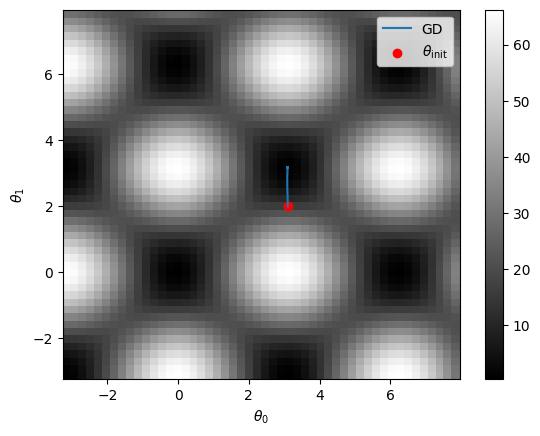

In [130]:
tmp_theta = np.copy(theta_init)
n_steps = 100
rate = 0.01
n_shots = 1000
theta_history_naive_gd = np.zeros((n_steps+1, 2))
theta_history_naive_gd[0] = theta_init
for i in range(n_steps):
    tmp_theta -= rate*get_cost_gradient(X, y, tmp_theta, n_shots)
    theta_history_naive_gd[i+1] = tmp_theta
plt.pcolor(theta0, theta1, cost_grid, shading="nearest", cmap="gray")
plt.plot(theta_history_naive_gd[:,0], theta_history_naive_gd[:,1], label="GD")
plt.colorbar()
plt.scatter(*theta_init, color="red", label=r"$\theta_{\mathrm{init}}$")
plt.xlabel(r"$\theta_0$")
plt.ylabel(r"$\theta_1$")
plt.legend()
plt.show()

正確な関数と見比べると、

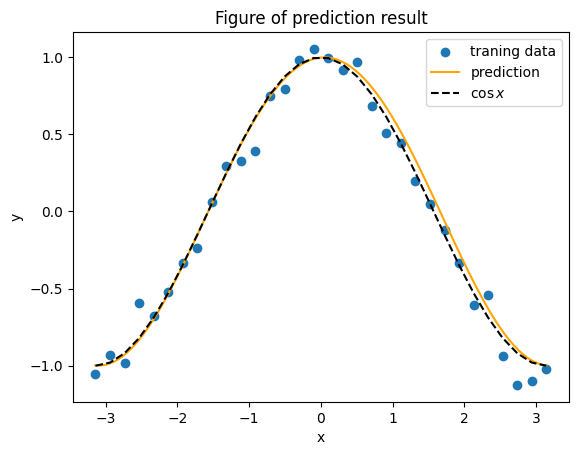

In [148]:
X_verify = np.linspace(-np.pi, np.pi, 100)
prediction = [predict(x, tmp_theta, n_shots=np.inf) for x in X_verify]
plt.scatter(X, y, label="traning data")
plt.plot(X_verify, prediction, color="orange", label="prediction")
plt.plot(X, y_clean, color="black", linestyle="dashed", label="$\cos{x}$")
plt.title("Figure of prediction result")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.show()